# scTour inference – Post-inference adjustment

This notebook shows how to perform post-inference adjustment when the returned pseudotime and vector field estimates are in the reversed order. This notebook uses the dataset from dentate gyrus neurogenesis.

In [2]:
import sctour as sct
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Import the data. The data is downloaded from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE95315)

In [3]:
info = pd.read_csv('../../../GSE95315_10X_expression_data_v2.tab', index_col=0, sep='\t', nrows=2)
count = pd.read_csv('../../../GSE95315_10X_expression_data_v2.tab', index_col=0, sep='\t', skiprows=[1, 2]).T
adata = sc.AnnData(X=count)
adata.obs['cluster'] = info.loc['cluster_name']

Select the cell types along the granule cell lineage.

In [4]:
ind = np.isin(adata.obs['cluster'], ['Granule-mature', 'Granule-immature', 'Neuroblast_2', 'Neuroblast_1', 'nIPC'])
adata = adata[ind, :]
adata.shape

(4007, 14545)

Relevel the cell type categories and assign colors to each cell type.

In [6]:
adata.obs['cluster'] = adata.obs['cluster'].astype('category')
adata.obs['cluster'].cat.reorder_categories(['nIPC', 'Neuroblast_1', 'Neuroblast_2', 'Granule-immature', 'Granule-mature'], inplace=True)

from matplotlib import cm, colors
cols = list(map(colors.to_hex, cm.tab20.colors))
adata.uns['cluster_colors'] = ['#aa40fc'] + [cols[i] for i in [3, 2, 1, 0]]

Count the number of genes detected in each cell. This is a necessary step before the scTour model training.

In [7]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
adata.obs

,cluster,n_genes_by_counts,total_counts
10X46_1_ATACCTTGAAGCCT-1,nIPC,1108,1627.0
10X46_1_GAGGCAGACTTCGC-1,nIPC,2105,4504.0
10X43_1_ACTCGCACTACGAC-1,nIPC,1558,3252.0
10X46_1_ATCGGAACCAATCG-1,nIPC,1864,4005.0
10X46_1_TCAGCGCTCGTCTC-1,nIPC,1341,2968.0
...,...,...,...
10X46_1_ATTGAATGCTCAGA-1,Granule-mature,1000,1690.0
10X46_1_CAGGTTGAAAAAGC-1,Granule-mature,1213,2003.0
10X46_1_GCCAACCTGGAACG-1,Granule-mature,1155,1847.0
10X46_1_CCTCGAACAACCTG-1,Granule-mature,812,1281.0


Select highly variable genes

In [8]:
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000, subset=True)

/home/ql312/software/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


log-transform the count before running scTour when you use the "nb" mode.

In [9]:
adata.X = np.log1p(adata.X)

Train the scTour model.

In [10]:
tnode = sct.train.Trainer(adata)
tnode.train()

Epoch 400: 100%|██████████| 400/400 [17:07<00:00,  2.35s/epoch, train_loss=553, val_loss=544]


Infer the developmental pseudotime and latent space. As shown in the previous tutorial, users can adjust the two parameters alpha_z and alpha_predz based on their purposes.

In [13]:
adata.obs['ptime'] = tnode.get_time()
mix_zs, zs, pred_zs = tnode.get_latentsp(alpha_z=0.2, alpha_predz=0.8)
adata.obsm['X_TNODE'] = mix_zs

Generate a UMAP embedding based on the inferred latent space.

In [14]:
adata = adata[np.argsort(adata.obs['ptime']), :]
sc.pp.neighbors(adata, use_rep='X_TNODE', n_neighbors=15)
sc.tl.umap(adata, min_dist=0.1)

Visualize the estimated pseudotime.

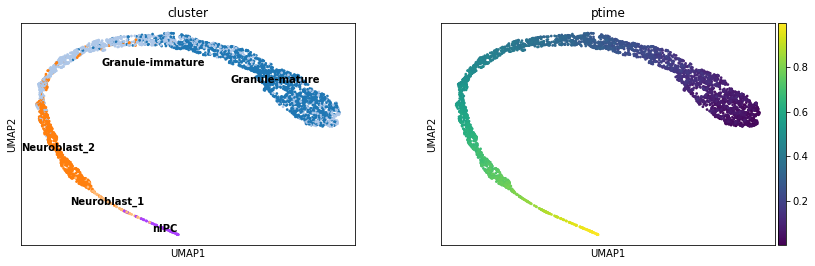

In [18]:
sc.pl.umap(adata, color=['cluster', 'ptime'], legend_loc='on data')

Since there exist two directions for integration when solving an ODE, the returned pseudotime estimate can be in the correct or reversed order. Although scTour takes into account the gene counts which are shown to be anti-correlated with developmental potential, this rule does not fit all data. scTour provides a post-inference function to reverse the returned estimates when such cases occur.

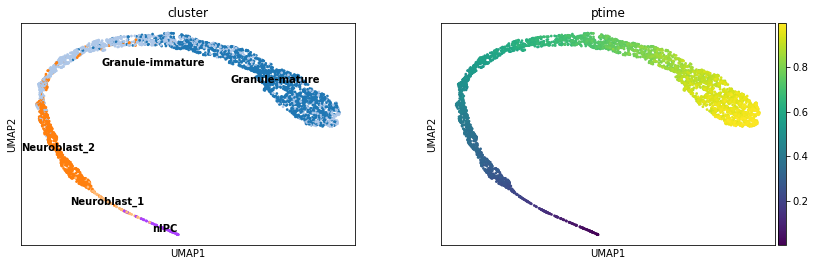

In [19]:
adata.obs['ptime'] = sct.train.reverse_time(adata.obs['ptime'].values)
sc.pl.umap(adata, color=['cluster', 'ptime'], legend_loc='on data')

Infer the vector field.

In [20]:
adata.obsm['X_VF'] = tnode.get_vector_field(adata.obs['ptime'].values, adata.obsm['X_TNODE'])

Visualize the vector field. Since the pseudotime is reversed, the vector field should be correspondingly reversed by setting the parameter "reverse" to be True when using the function sct.vf.plot_vector_field. This function needs the users to provide the ax parameter as shown below.

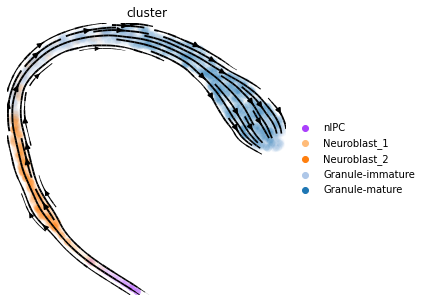

In [23]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
sct.vf.plot_vector_field(adata, reverse=True, zs_key='TNODE', vf_key='VF', use_rep_neigh='TNODE', ax=ax, color='cluster', frameon=False,size=200, alpha=0.05)
plt.show()